# The effect of data augmentation for image classification
## Abstract
Data augmentation generates new images from a dataset. It can be useful for when you're lacking data, need to balance the number of samples in each class, or want to prevent overfitting. Data augmentation achieves this by taking samples already in the dataset and applying transformations to generate new data. This tutorial aims to explain and show the effect of data augmentation by providing code that creates the transformations which can be used on any image dataset. We will compare a model trained with data augmentation to one trained without to see the effect on the final classification.

---
## Objectives
* Load an image dataset
* Create a basic CNN model
* Test the effect of different hyper-parameters on a base model
* Create a transformation to augment data
* Train a model using data augmentation
* Compare results of data augmentation and base model with best performing hyper-parameters
  
---
## Table of Contents
1. [Loading Data](#data)
2. [Model Creation](#model)
3. [Defining Training Loop](#train)
4. [Hyper-paramter Testing](#hyper-parameter)
5. [Augmenting Data and Training a Model](#augmentation)
6. [Comparing Model Results](#results)
7. [Conclusion](#conclusion)

---
## Difference to Other Tutorials

Looking online, there's a lot of tutorials implementing data augmentation. Here we'll look at some and discuss the common place where they fall short.

Source [1] shows a tutorial implementing different types of transformations on images for a cat breed dataset. This tutorial is good at visualising and understanding how the transformations work, making it preferred over reading documentation. The main issue however is whilst it provides the techniques to implement data augmentation, the overall impact of it is never tested or mentioned.

Source [2] is a tutorial that is specifically looking at training a model using data augmentation. This again is good at visualising the transformations and then showing how to apply the augmentation whilst training. Whilst it does plot the results after using data augmentation, there's still no comparison to a base model to help users understand why it's a key step in training for image classification.

Searching for a tutorial on the effect of data augmentation only results in learning how to implement it. No tutorials are going that extra step of comparing models to visually show the impact on training. That's the reason for this tutorial, to show not only how to apply data augmentation during image classification, but to also show how it affects the training process.

---


In [1]:
import torch

device = ("cuda" 
          if torch.cuda.is_available() 
          else "cpu"
         )

The first thing we do is set the device for training. This will allow for quicker training if we are able to use cuda.

## Loading Data <a name="data"></a>

Here load the dataset that we're using to train. The images are stored locally, split into train and test, then into folders that represent their classes. 

The data used in this tutorial was downloaded from source [3]

In [2]:
from pathlib import Path

cwd = Path.cwd()

# Creating path to our train and test sets
train_path = cwd.joinpath("images/small_training/")
test_path = cwd.joinpath("images/test_set/")


In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset

# Data set creation adpated from source [4]
class ImageDataset(Dataset):
    
    def __init__(self, dir, transform=None):
        self.paths = list(Path(dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes = sorted(entry.name for entry in os.scandir(dir) if entry.is_dir())
        self.class_to_id = {cls: i for i, cls in enumerate(self.classes)}

    def load_img(self, index):
        path = self.paths[index]
        return Image.open(path)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        img = self.load_img(index)
        cls = self.paths[index].parent.name
        cls_id = self.class_to_id[cls]
        if self.transform:
            return self.transform(img), cls_id
        else:
            return img, cls_id
# End of source[4]
            

This dataset class is used to load our dataset. Target directory (train or test) and transformations are passed when creating an instance. The transformation part will be used to convert data into tensor format and will later be used for data augmentation.

Code references [4]

In [4]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import random_split

# Creating transform to turn into tensors
# This is different to the other transforms mentioned
transform=transforms.Compose([transforms.Resize((227, 227)), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

# Initialising our train, validation, and test data
train_data = ImageDataset(train_path, transform)
test_set = ImageDataset(test_path, transform)
testSize = int(round(0.6 * len(test_set)))
# Splitting for validation set as it doesn't come with the dataset
test_data, validation_data = random_split(test_set, [testSize, len(test_set) - testSize])

# Creating loaders for train and test to use in the model
train_loader = DataLoader(train_data, batch_size = 1, shuffle = True)
validation_loader = DataLoader(validation_data, shuffle = False)
test_loader = DataLoader(test_data, shuffle = False)


Here we just create instances for training, as well as a simple transformation to help training. Dataloaders are requried to pass the data when training.

## Model Creation <a name="model"></a>

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Simple network for image classification adapted from source [5]
class SimpleNet(nn.Module):
    def __init__(self, out_shape):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, out_shape)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
# End of source [5]


This model is just a simple CNN. Images will go through the forward pass during training.

Code references [5]

## Defining Training Loop <a name="train"></a>

In [6]:
import torch.optim as optim
# Creating loss function
loss_func = nn.CrossEntropyLoss()


In [17]:
def training_loop(epochs, data_loader, model, display_loss):
    training_loss = []
    validation_loss = []
    for epoch in range (epochs):
        print("Current Epoch: "+ str(epoch + 1))
        training_loss.append(sum_loss(data_loader, model, len(train_data)))
        validation_loss.append(sum_loss(validation_loader, model, len(validation_data)))
        
        model.train()
        for i, (x, y) in enumerate (data_loader, 0):
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()

            pred_y = model(x)
            loss = loss_func(pred_y, y)
            loss.backward()
            optimizer.step()

            if i == round(len(train_data)/2) :
                # Calculates loss on half an epoch
                training_loss.append(sum_loss(data_loader, model, len(train_data)))
                validation_loss.append(sum_loss(validation_loader, model, len(validation_data)))
                model.train()
        if display_loss:
            print("Train Accuracy: "+str(accuracy(data_loader, model, len(train_data))))
            print("Val Accuracy: "+str(accuracy(validation_loader, model, len(validation_data))))

    # Final loss
    training_loss.append(sum_loss(data_loader, model, len(train_data)))
    validation_loss.append(sum_loss(validation_loader, model, len(validation_data)))
    return training_loss, validation_loss

# Calculates the average loss of a model on data from a dataloader
def sum_loss(loader, model, size):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, (x, y) in enumerate (loader, 0):
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = loss_func(output, y)
            total_loss += loss
    avg_loss = (total_loss / size)
    return avg_loss.item() 

# Calculates the average accuracy of a model on data from a dataloader
def accuracy(loader, model, size):
    model.eval()
    accuracy_sum = 0.0
    
    with torch.no_grad():
        for i, (x, y) in enumerate(loader, 0):
            x, y = x.to(device), y.to(device)
            output = model(x)
            _, pred_y = torch.max(output.data, 1)
            accuracy_sum += (pred_y == y).sum().item()
         
    accuracy = ((100* accuracy_sum) / size)
    return accuracy


Here we define the training loop, this uses the dataloaders to train our model instances. The loss and accuracy functions generate information that will be used for evaluation later.

## Hyper-parameter Testing <a name="hyper-parameter"></a>

### Learning Rate
To test learning rate we create 3 different models looking at low, medium, and high learning rates. We train each for 15 epochs and then examine the results below.

In [ ]:
# Testing starting learning rate
epochs = 15

# Low
model1 = SimpleNet(2).to(device)
optimizer = optim.Adam(model1.parameters(), lr=0.00001)
low_lr_training_loss, low_lr_validation_loss = training_loop(epochs, train_loader, model1, False)

# Middle
model2 = SimpleNet(2).to(device)
optimizer = optim.Adam(model2.parameters(), lr=0.0001)
mid_lr_training_loss, mid_lr_validation_loss = training_loop(epochs, train_loader, model2, False)

# High
model3 = SimpleNet(2).to(device)
optimizer = optim.Adam(model3.parameters(), lr=0.001)
high_lr_training_loss, high_lr_validation_loss = training_loop(epochs, train_loader, model3, False)


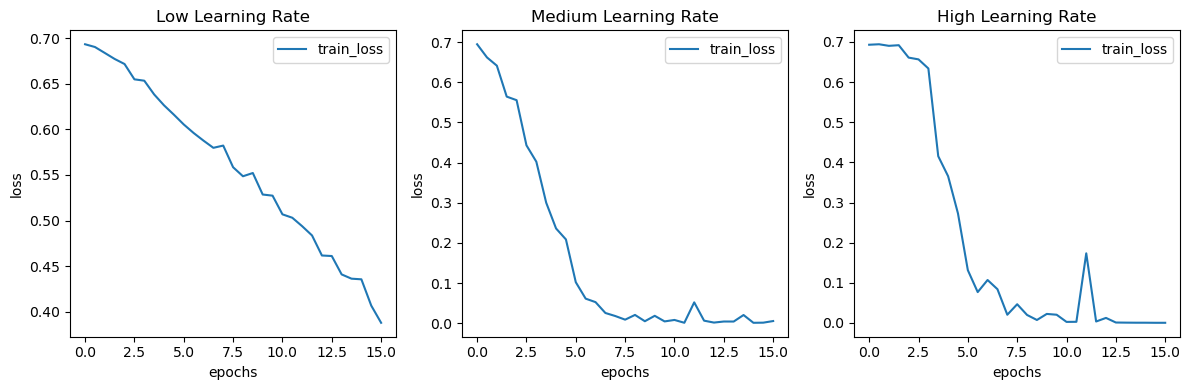

In [9]:
from matplotlib import pyplot as plt
# Plotting results
epoch_list = []

for x in range (epochs):
    epoch_list.append(x)
    epoch_list.append(x + 0.5)
epoch_list.append(epochs)

plt.subplots(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(epoch_list, low_lr_training_loss, label="train_loss")
plt.title("Low Learning Rate")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(1, 3, 2)
plt.plot(epoch_list, mid_lr_training_loss, label="train_loss")
plt.title("Medium Learning Rate")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(1, 3, 3)
plt.plot(epoch_list, high_lr_training_loss, label="train_loss")
plt.title("High Learning Rate")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.tight_layout()

plt.show()

### Learning Rate Results
As we can see from the above graphs, our low learning rate is too slow and would take too long to train.

The other two leraning rate tests both approach a steady losss with fluctuations, the medium approaching faster. I'm choosing to use the medium learning rate in this situation as it's less likely to overfit to the data as quickly as a high one.

Below we now test the weight decay hyper-parameter with our decided learning rate of 0.0001.

### Weight Decay
Testing weight decay is the same process as learning rates.

In [ ]:
# Testing weight decay

# Low
model4 = SimpleNet(2).to(device)
optimizer = optim.Adam(model4.parameters(), lr=0.0001, weight_decay=0.0001)
low_wd_training_loss, low_wd_validation_loss = training_loop(epochs, train_loader, model4, False)

# Middle
model5 = SimpleNet(2).to(device)
optimizer = optim.Adam(model5.parameters(), lr=0.0001, weight_decay=0.001)
mid_wd_training_loss, mid_wd_validation_loss = training_loop(epochs, train_loader, model5, False)

# High
model6 = SimpleNet(2).to(device)
optimizer = optim.Adam(model6.parameters(), lr=0.0001, weight_decay=0.01)
high_wd_training_loss, high_wd_validation_loss = training_loop(epochs, train_loader, model6, False)

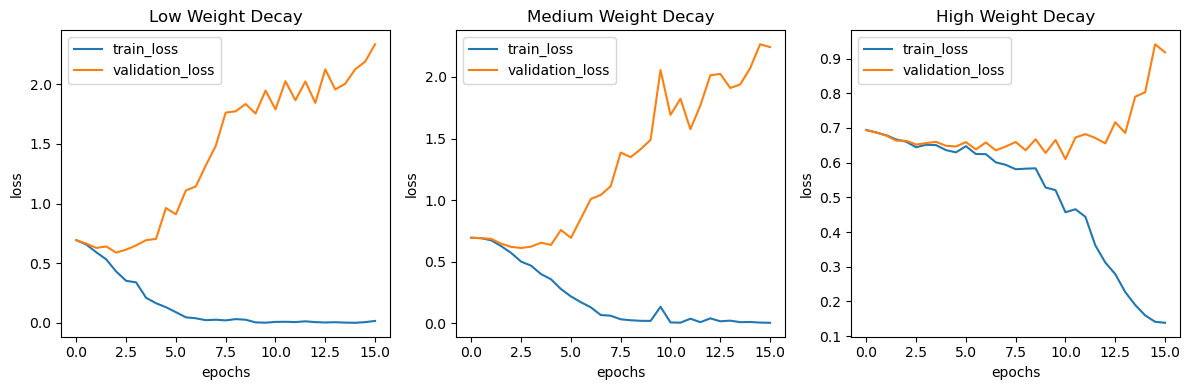

In [13]:
# Plotting results
plt.subplots(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(epoch_list, low_wd_training_loss, label="train_loss")
plt.plot(epoch_list, low_wd_validation_loss, label="validation_loss")
plt.title("Low Weight Decay")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(1, 3, 2)
plt.plot(epoch_list, mid_wd_training_loss, label="train_loss")
plt.plot(epoch_list, mid_wd_validation_loss, label="validation_loss")
plt.title("Medium Weight Decay")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(1, 3, 3)
plt.plot(epoch_list, high_wd_training_loss, label="train_loss")
plt.plot(epoch_list, high_wd_validation_loss, label="validation_loss")
plt.title("High Weight Decay")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.tight_layout()

plt.show()


|Training|Train Loss|Validation Loss|Test Accuracy|
|:-:|:-:|:-:|:-:|
|Low Weight Decay|0.011|2.341|61.287|
|Medium Weight Decay|0.001|2.122|62.557|
|High Weight Decay|0.135|0.968|63.427|

### Weight Decay Results
Plotting and showing the validation loss is important to be able to see if overfitting occurs, by how much, and when. From the data above we can clearly see that all 3 models overfit quite quickly due to the validation loss diverging from the training loss early on them.

Weight decay is meant to help prevent overfitting so being able to see the two losses side by side is very helpful to determine which weight decay value is the best.

Whilst all models do overfit, we can see from the graphs and table that the high weight decay does so the least, resulting in the highest accuracy. Because of this, I am choosing the high weight decay model to be the one that we compare against the model using data augmentation.


In [14]:
# Renaming to make code clearer when testing
base_model = model6


## Augmenting Data and Training a Model  <a name="augmentation"></a>
Due to how we've set up the dataset, we can pass a transformation into it. The transformation is then applied every time that the dataloader gets a new batch. This means that if we use some random transformations, the training won't repeatedly see the same images.

### Creating Transformation

In [15]:
from torchvision import transforms

# Transform is combining multiple different transforms in one
# Standard transformations, learnt from source [1]
random_transform = transforms.RandomApply(nn.ModuleList([transforms.RandomHorizontalFlip(p=0.5),
                                                         transforms.RandomResizedCrop(480, (0.6, 1)),
                                                         transforms.RandomAffine(60, (0, 0.2), (0.8, 1)),
                                                         transforms.ColorJitter(brightness = 0.3, hue = 0.2),]), p=0.95)
# End of source [1]

display_transform = transforms.Compose([random_transform, transforms.Resize((227, 227)), transforms.ToTensor()])
# Display transform used to show images below
data_transform = transforms.Compose([random_transform, transforms.Resize((227, 227)), transforms.ToTensor(), 
                                     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
# Data transform is what will be used when training

display_data = ImageDataset(train_path, display_transform)
random_data = ImageDataset(train_path, data_transform)

augmented_loader = DataLoader(random_data, batch_size = 1, shuffle = True,)
image_loader = DataLoader(display_data, batch_size = len(display_data), shuffle = False)
# Setting batch size to size of the data to easily display the same image coming from the data loader


Our random transform can apply a horizontal flip, can crop and resize the image, can rotate, translate, and scale the image (affine transformation), and can adjust brightness and hue. On top of this, there's an assigned probability of 95% so that the training does still get some images that haven't been transformed.

We then do the standard transforms to resize, turn it into a tensor, and normalize.

The image loader doesn't have the normalization so the below displayed images just show the random transform.

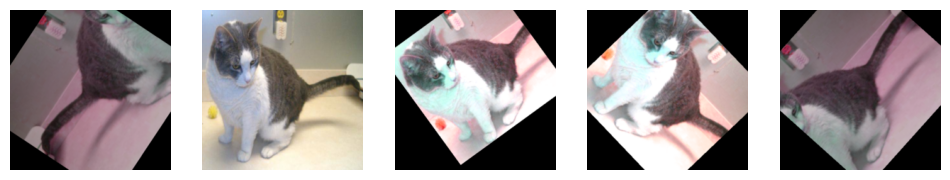

In [16]:
from matplotlib import pyplot as plt
def display_images(images):
    # Displays given list of images
    plt.subplots(figsize=(12, 4))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

cats = []
for x in range (5):
    for i, (x, y) in enumerate(image_loader):
        cats.append(x[88].permute(1,2,0))
        # Number 88 is my favourite cat

display_images(cats)


The above images show that the random transformation created is applying to each image every epoch, rather than being set once, this means that training will be fed new images it hasn't seen that should prevent the quick overfitting that was being seen earlier

### Training Augmented Data Model

In [ ]:
# Training
augmented_model = SimpleNet(2).to(device)
optimizer = optim.Adam(augmented_model.parameters(), lr=0.0004)
# Using a higher learning rate as training will take longer due to data not being the same every epoch
epochs = 20
augmented_training_loss, augmented_validation_loss = training_loop(epochs, augmented_loader, augmented_model, True)


## Comparing Model Results <a name="results"></a>

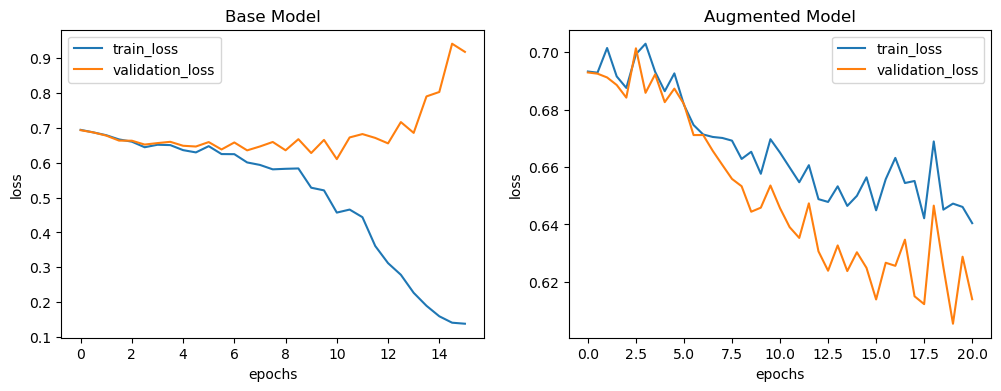

In [22]:
from matplotlib import pyplot as plt
# Plotting results
epoch_list = []

for x in range (20):
    epoch_list.append(x)
    epoch_list.append(x + 0.5)
epoch_list.append(epochs)

plt.subplots(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epoch_list[:31], high_wd_training_loss, label="train_loss")
plt.plot(epoch_list[:31], high_wd_validation_loss, label="validation_loss")
plt.title("Base Model")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.plot(epoch_list[:41], augmented_training_loss[:41], label="train_loss")
plt.plot(epoch_list[:41], augmented_validation_loss[:41], label="validation_loss")
plt.title("Augmented Model")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()



The above graphs show the results of training with augmented data and without.

As discussed in the earlier part when deciding hyperparameters, the model with no data augmentation overfits to the training set very quickly. We can see this in the graph as the validation error diverges greatly from the training error that gets very small.

Looking at the model trained using an augmented data loader, we can see that the validation and training errors follow very closely during training, with error gradually decreasing. Obviously, looking at the y-axis we can see that the training error doesn't get near what the base training gets however, it's likely due to the lack of complexity of the model meaning it doesn't find the features it needs to.

Another reason could be that data augmentation naturally takes longer to train due to images having different properties to the dataset. Having the data augmentation be online (augmented every epoch) means that the dataset is constantly changing so the model finding the right things to focus on takes even longer.

| Training | Accuracy|
|:--------:|:-------:|
| Base Model| 63.427 |
| Augmented Model | 69.204 |

Above are the accuracies on the test data.

As we can see, the augmented data model outperforms the base model due to it not overfitting on the data. Whilst an accuracy of 68% isn't the end goal of the system, this is a good way of showing the effect data augmentation has.

Given a model that's more complex and the time to train it, the augmented model will always outperform on unseen data.

## Conclusion <a name="conclusion"></a>
The goal of this tutorial was to show the effect of data augmentation for image classification. The results successfully show that it helps prevent overfitting, shown by train and validation errors staying close during training.

Whilst the end model provided by data augmentation isn't optimal, likely due to the implemented model, it still succeeds in showing that data augmentation is effective. More complex models weren't implemented due to current training time being quite long.


## References
* [1] https://www.kaggle.com/code/reichenbch/image-transformations
* [2] https://d2l.ai/chapter_computer-vision/image-augmentation.html
* [3] https://www.kaggle.com/datasets/tongpython/cat-and-dog/data
* [4] https://www.kaggle.com/code/tnguynfew/dog-cat-classification-with-vgg16-using-pytorch
* [5] https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html